In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from tqdm import tqdm

import timeit
import time
import math

# ./indexer
from indexer import AppendIndexer
import ALS

# Annoy
from annoy import AnnoyIndex

#SKLearn 
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import average_precision_score
from sklearn.metrics import pairwise_distances

# scipy
from scipy.spatial import distance
from scipy.sparse import lil_matrix

In [2]:
def calc_acc(annoy_indices, knn_indices, k):
    aa = []
    for i in range(len(annoy_indices)):
        b = []
        for j in annoy_indices[i][1:]:
            if j in knn_indices[i][:k]:
                b.append(1)
            else:
                b.append(0)
        aa.append(b)
    res2 = []
    for a in aa:
        acc2 = 0
        for i in range(len(a)):
            acc2 += a[i]
        if not len(a):
            res2.append(0)
        else:
            res2.append(acc2/len(a))
    return np.array(res2).mean()
def calc_nDCG(annoy_indices, knn_indices, k, discount = 3):
    aa = []
    for i in range(len(annoy_indices)):
        b = []
        for j in annoy_indices[i][1:]:
            if j in knn_indices[i][:k]:
                b.append(1)
            else:
                b.append(0)
        aa.append(b)
    res = []
    for a in aa:
        acc = 0
        for i in range(len(a)):
            acc += a[i]/math.log(i+7, 7)
        if not len(a):
            res.append(0)
        else:
            res.append(acc/len(a))
    return np.array(res).mean()


## loading data

In [3]:
chetor_content = pd.read_csv('./pages_chetor.csv')
chetor_content.head(20)

,id,created,content_vector,title,cleaned_url,website_id,included,is_amp,has_image_meta,has_title_meta,page_id,subdomain_id,title_vector,image_id,cats
0,2177439,2020-08-09 04:51:12.676435+04:30,"{0.52510529756546,-0.51316374540329,-0.3844181...",وردپرس › خطا,chetor.com/,1,f,f,f,f,148948,336,"{-0.90155690908432,-1.60752034187317,0.1689879...",1015133.0,{}
1,973115,2020-08-09 03:50:47.939727+04:30,"{-0.111537165939808,0.314831465482712,-0.60968...",تبلیغات در وب سایت چطور | چطور,chetor.com/%D8%AA%D8%A8%D9%84%DB%8C%D8%BA%D8%A...,1,t,f,f,t,27016495,336,"{-1.89593696594238,0.659652948379517,-0.852037...",NaN,{}
2,975692,2020-08-09 03:50:49.22613+04:30,"{0.628654301166534,-0.548453748226166,-0.25651...",همکاری با ما | چطور,chetor.com/%D9%87%D9%85%DA%A9%D8%A7%D8%B1%DB%8...,1,t,f,f,t,27004594,336,"{-2.04737234115601,2.28955912590027,-2.1406197...",333341.0,{}
3,2144818,2020-08-09 04:49:41.361098+04:30,"{0.350972026586533,-0.0532753616571426,-0.2103...",چرا باید توسعه فردی را جدی بگیرید؟- چطور,chetor.com/100-%DA%86%D8%B1%D8%A7-%D8%A8%D8%A7...,1,t,f,f,f,5274753,336,"{2.27225732803345,0.7027268409729,0.4857064485...",599277.0,{}
4,2157999,2020-08-09 04:50:09.423651+04:30,"{1.79109728336334,-1.05194425582886,-1.3205879...",دلایل سرد بودن دستان چیست؟ | چطور,chetor.com/100026-%D8%B3%D8%B1%D8%AF-%D8%A8%D9...,1,t,f,f,f,2416997,336,"{2.48906230926514,-1.19906878471375,-1.4995402...",1485027.0,{}
5,4465070,2020-10-06 11:10:31.622853+03:30,"{0.683604598045349,-0.237597540020943,0.257590...",افسوس های من | چطور,chetor.com/100041-%D8%A7%D9%81%D8%B3%D9%88%D8%...,1,t,f,t,t,38243000,336,NaN,1012527.0,{}
6,2142257,2020-08-09 04:49:40.250501+04:30,"{0.63472980260849,0.145868331193924,0.12041924...",خانه پدربزرگ | چطور,chetor.com/100044-%D8%AE%D8%A7%D9%86%D9%87-%D9...,1,t,f,f,f,6160851,336,"{1.89609825611115,1.75975489616394,2.689968109...",1012527.0,{}
7,2123739,2020-08-09 04:48:50.486508+04:30,"{0.63071072101593,-0.431413412094116,-0.302038...",درددل های زیادی در دل اطرافیانم مانده | چطور,chetor.com/100049-%D8%AF%D8%B1%D8%AF%D8%AF%D9%...,1,t,f,f,f,11269955,336,"{1.16336917877197,0.0402661710977554,0.3318648...",NaN,{}
8,2161889,2020-08-09 04:50:45.622368+04:30,"{2.3618381023407,-0.220653653144836,-1.4399104...",درمان سردرد و تسکین فوری آن با ۱۴ روش موثر و ی...,chetor.com/100085-%D8%AF%D8%B1%D9%85%D8%A7%D9%...,1,t,f,f,f,2262178,336,"{2.5592200756073,0.69496887922287,-2.160656929...",1013280.0,{}
9,2161493,2020-08-09 04:50:45.464757+04:30,"{1.23862218856812,-0.99531877040863,-0.5665395...",آیا موز چاق کننده است؟ | چطور,chetor.com/100187-%D8%A2%DB%8C%D8%A7-%D9%85%D9...,1,t,f,f,f,2273389,336,"{1.81400036811829,-1.17559599876404,-1.4106029...",1013170.0,{}


In [4]:
print(chetor_content.shape)

(9640, 15)


In [5]:
chetor_content = chetor_content[chetor_content.included == 't']
chetor_content.shape

(8723, 15)

In [6]:
class ViewMatrix:
    def __init__(self, path):
        self.path = path
        self.original = True
        self.item_indexer = AppendIndexer.load('./chetor.com/view_matrix/item_indexer.indexer')
        self.user_indexer = AppendIndexer.load('./chetor.com/view_matrix/user_indexer.indexer')
        
    def load_matrix(path):
        
        matrix = ViewMatrix(path)

        try:
            matrix.view_matrix = ViewMatrix \
                .load_sparse_lil(path)
        except:
            print('Error: loading', path)

        return matrix

    def load_sparse_lil(filename):
        loader = np.load(filename, allow_pickle=True)
        result = lil_matrix(tuple(loader["shape"]), dtype=str(loader["dtype"]))
        result.data = loader["data"]
        result.rows = loader["rows"]
        return result
    
    def make_dense(self, user_min_view, item_min_view):
        self.original = False
        while True:
            removed_rows_cnt = self.trim_users_with_few_views(user_min_view)
            removed_columns_cnt = self.trim_columns_with_few_views(item_min_view)
            if not removed_columns_cnt and not removed_rows_cnt:
                break

    def trim_users_with_few_views(self, user_min_view):
        removing_row_indices = list(np.where(self.view_matrix.getnnz(1) < user_min_view)[0])
        print('Number of users which should be deleted:', len(removing_row_indices))
        self.trim_user_indices(to_remove_indices=removing_row_indices)
        return len(removing_row_indices)

    def trim_columns_with_few_views(self, column_min_view):
        removing_column_indices = list(np.where(self.view_matrix.getnnz(0) < column_min_view)[0])
        print('Number products which should be deleted:', len(removing_column_indices))
        self.trim_column_indices(to_remove_indices=removing_column_indices)
        return len(removing_column_indices)
    
    def trim_user_indices(self, to_remove_indices):
        self.user_indexer.remove_indexes(to_remove_indices)
        self.view_matrix = ViewMatrix.delete_row_lil(self.view_matrix, to_remove_indices)
    
    def trim_column_indices(self, to_remove_indices):
        self.item_indexer.remove_indexes(to_remove_indices)
        self.view_matrix = ViewMatrix.delete_column_lil(self.view_matrix, to_remove_indices)
    
    def delete_column_lil(mat: lil_matrix, *i) -> lil_matrix:
        mat = mat.transpose()
        mat = ViewMatrix.delete_row_lil(mat, *i)
        return mat.transpose()
    
    def delete_row_lil(mat: lil_matrix, *i) -> lil_matrix:
        if not isinstance(mat, lil_matrix):
            raise ValueError("works only for LIL format -- use .tolil() first")
        mat = mat.copy()
        mat.rows = np.delete(mat.rows, i)
        mat.data = np.delete(mat.data, i)
        mat._shape = (mat.rows.shape[0], mat._shape[1])
        return mat
    def to_csr(self):
        train_data = self.view_matrix.astype(np.float64)
        train_data = train_data.tocoo()
        train_data.data = np.log10(train_data.data) + 1
        train_data = train_data.tocsr()
        return train_data

## colaborative filtering train

In [7]:
def CFTrain(path: str, _alpha = 15, factors = 20):
    now = time.time()
    matrix = ViewMatrix.load_matrix(path)
    print('View matrix loaded in', time.time() - now, 'seconds.')

    now = time.time()
    sparce_matrix = matrix.to_csr()
    matrix.make_dense(user_min_view = 2, 
                      item_min_view = 2)
    print('matrix has been made dense in', time.time() - now, 'seconds.')

    als_model = ALS.Als(num_factors = factors,
                        iterations = 15,
                        num_threads = 15,
                        alpha = _alpha)

    implicit_matrix = matrix.to_csr()

    print()
    now = time.time()
    als_model.fit(implicit_matrix)
    alsTime = time.time() - now
    print('ALS model is fitted in', time.time() - now, 'seconds.')
    
    print('Saving Data ...')
    matrix.item_indexer.dump('./chetor.com/alisResult/ali_item_indexer_factorized.indexer')
    matrix.user_indexer.dump('./chetor.com/alisResult/ali_user_indexer_factorized.indexer')
    np.save('./chetor.com/alisResult/ali_items_vectors.npy', als_model.item_vectors)
    np.save('./chetor.com/alisResult/ali_users_vectors.npy', als_model.user_vectors)
    
    return sparce_matrix, implicit_matrix, als_model.item_vectors, als_model.user_vectors, alsTime

In [8]:
sparce_matrix, implicit_matrix, item_vectors, user_vectors, alsTime = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 20)

View matrix loaded in 7.968033313751221 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 19.1260769367218 seconds.

ALS model is fitted in 13.905150175094604 seconds.
Saving Data ...


In [9]:
sparce_matrix40, implicit_matrix40, item_vectors40, user_vectors40, alsTime40 = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 40)

View matrix loaded in 7.137897968292236 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 17.802146196365356 seconds.

ALS model is fitted in 204.27747440338135 seconds.
Saving Data ...


In [10]:
# implicit_matrix = implicit_matrix.toarray()
# sparce_matrix = sparce_matrix.toarray()

In [11]:
sparce_matrix.shape

(2097150, 8190)

In [12]:
implicit_matrix.shape

(233197, 6877)

## KNN Models

In [13]:
def sk_KNN(item_vectors, number_of_neighbours = 30):
    start = time.time()

    knn_distances_brute = []
    knn_indices_brute = []

    nbrs = NearestNeighbors(n_neighbors=number_of_neighbours, algorithm='ball_tree'). \
        fit(item_vectors)

    knn_distances_brute, knn_indices_brute = nbrs.kneighbors(item_vectors)

    end = time.time()
    print('ball_tree time:', end-start)
    
    return knn_distances_brute, knn_indices_brute

In [14]:
def sk_KNN_c(item_vectors, mapper, number_of_neighbours = 30):
    start = time.time()

    knn_distances_brute = []
    knn_indices_brute = []

    nbrs = NearestNeighbors(n_neighbors=number_of_neighbours, algorithm='ball_tree'). \
        fit(item_vectors)

    knn_distances_brute, knn_indices_brute = nbrs.kneighbors(item_vectors)

    end = time.time()
    print('ball_tree time:', end-start)
    a = [[mapper[j] for j in i]for i in knn_indices_brute]
    
    return knn_distances_brute, a

In [15]:
def get_annoy_results(pages_vector, number_of_trees = 170, number_of_neighbours = 30):
    
    start = time.time()
    annoy_model = annoy_model = AnnoyIndex(pages_vector.shape[1], 'angular')
    
    for index, vector in enumerate(pages_vector):
        annoy_model.add_item(index, vector)
    
    annoy_model.build(number_of_trees)
    
    annoy_indices = []
    annoy_distances = []

    for i in pages_vector:
        indices, distances = annoy_model. \
            get_nns_by_vector(i, number_of_neighbours, include_distances=True)
        annoy_indices.append(indices)
        annoy_distances.append(distances)
    
    duration = time.time() - start
    print('annoy time:', duration)
    return annoy_indices, annoy_distances, duration

In [16]:
def get_annoy_results_c(pages_vector, number_of_trees = 170, number_of_neighbours = 30):
    
    start = time.time()
    annoy_model = annoy_model = AnnoyIndex(300, 'angular')
    
    for index, vector in pages_vector.items():
        annoy_model.add_item(index, vector)
    
    annoy_model.build(number_of_trees)
    
    annoy_indices = []
    annoy_distances = []

    for j, i in pages_vector.items():
        indices, distances = annoy_model. \
            get_nns_by_vector(i, number_of_neighbours, include_distances=True)
        annoy_indices.append(indices)
        annoy_distances.append(distances)
    
    duration = time.time() - start
    print('annoy time:', duration)
    return annoy_indices, annoy_distances, duration

## Runing KNN collaborative filtering

In [17]:
annoy_indices_CF, annoy_distances, duration = get_annoy_results(item_vectors)

annoy time: 6.241101503372192


In [18]:
knn_distances_brute, knn_indices_brute = sk_KNN(item_vectors)

ball_tree time: 1.4761583805084229


In [19]:
print(annoy_indices_CF[5744])
print(knn_indices_brute[5744])

[5744, 4041, 4886, 5025, 1284, 1057, 5772, 1427, 5510, 2189, 6161, 5674, 4774, 2647, 6048, 4556, 5548, 3276, 2554, 3043, 5484, 2543, 3530, 3042, 3226, 2606, 2642, 2492, 6677, 5107]
[5744 5772 2798 4758 6639 5346 5360 5337 3792 2642 3584 4041 2081 5836
 4780 6527 5008 4867 4712 5910 4726 5034 4472 5630 4794 4846 6168 5759
  594 4941]


In [20]:
item_indexer1 = \
AppendIndexer.load('./chetor.com/alisResult/ali_item_indexer_factorized.indexer')

In [21]:
chetor_content[chetor_content['id'] == int(item_indexer1.reverse_get(4539))]
# chetor_content[chetor_content['id'] == int(item_indexer1.reverse_get(3357))]
# chetor_content[chetor_content['id'] == int(item_indexer1.reverse_get(1364))]
# chetor_content[chetor_content['id'] == int(item_indexer1.reverse_get(800))]

,id,created,content_vector,title,cleaned_url,website_id,included,is_amp,has_image_meta,has_title_meta,page_id,subdomain_id,title_vector,image_id,cats
5059,2156702,2020-08-09 04:50:08.834911+04:30,"{0.509120881557465,-1.08496379852295,-0.249915...",ارزیابی ۳۶۰ درجه چیست و چه مزایا و معایبی دارد...,chetor.com/23451-%D8%A7%D8%B1%D8%B2%DB%8C%D8%A...,1,t,f,f,f,2490645,336,"{1.02428507804871,-0.387193650007248,0.2601181...",139097.0,{}


## train content based

In [22]:
items = []
nulls = []
for i in item_indexer1.get_items():
    temp = {}
    try:
        item_index = item_indexer1.get(i)
        c_vec = np.array(chetor_content[chetor_content['id'] == int(i)].content_vector)[0]
        temp['content_vec'] = np.array([float(x) for x in str(c_vec)[1:-1].split(',')])
        temp['id'] = i
        temp['index'] = item_index
        items.append(temp)
    except:
        nulls.append(item_index)

In [23]:
item_content_map = {}
for i in items:
    item_content_map[i['index']] = i['content_vec']
content_vec = []
items_itex = []
for i, j in item_content_map.items():
    content_vec.append(j)
    items_itex.append(i)
# items_itex.index(1600)

In [24]:
annoy_indices_CB, annoy_distances_CB, duration_CB = get_annoy_results_c(item_content_map)

annoy time: 4.994776010513306


In [25]:
knn_distances_brute_CB, knn_indices_brute_CB = sk_KNN_c(content_vec, items_itex)

ball_tree time: 24.46805715560913


In [26]:
print(annoy_indices_CB[6300])
print(knn_indices_brute_CB[6300])

[6758, 3219, 3027, 2311, 4787, 4424, 1790, 1977, 6037, 5307, 5496, 3386, 2232, 1234, 6199, 3688, 2008, 5286, 1027, 3956, 4937, 2930, 6081, 3259, 6115, 4099, 618, 40, 5497, 5894]
[6758, 3027, 1790, 1977, 4424, 6037, 2311, 6081, 1027, 3956, 6199, 1390, 4787, 40, 5286, 4491, 5307, 1234, 2647, 5496, 3219, 5113, 3123, 5790, 1437, 5370, 4720, 2523, 4345, 5020]


In [27]:
chetor_content[chetor_content['id'] == int(item_indexer1.reverse_get(3123))]

,id,created,content_vector,title,cleaned_url,website_id,included,is_amp,has_image_meta,has_title_meta,page_id,subdomain_id,title_vector,image_id,cats
2365,2138598,2020-08-09 04:49:18.183412+04:30,"{0.675059735774994,-0.17669515311718,-0.160999...",تکنیک اتاق رومی؛ چطور هر فهرستی را به‌راحتی به...,chetor.com/158064-%D8%AA%DA%A9%D9%86%DB%8C%DA%...,1,t,f,f,f,7857591,336,"{0.926600635051727,0.212246716022491,0.1147326...",1012473.0,{}


## Annoy accuracy

collab

In [28]:
Tknn_distances_brute, Tknn_indices_brute = sk_KNN(item_vectors40, number_of_neighbours = 10)

ball_tree time: 3.330843210220337


In [30]:
allt2 = []
allndcgs2 = []
for i in tqdm(range(20)):
    tt = []
    accs = []
    ndcgs = []
    trees = [5,6,7,8, 10,12, 15, 20, 30, 35, 40, 45, 50, 60, 75, 100, 125, 150, 175, 200, 250,  300]
    for i in trees:
        Tannoy_indices_CF, Tannoy_distances, Tduration = get_annoy_results(item_vectors40, number_of_trees = i, number_of_neighbours = 10)
        tt.append(6877/Tduration)
        accs.append(calc_acc(Tannoy_indices_CF, Tknn_indices_brute, 10))
        ndcgs.append(calc_nDCG(Tannoy_indices_CF, Tknn_indices_brute, 10))
    allt2.append(tt)
    allndcgs2.append(ndcgs)
allt2 = np.array(allt2)
allndcgs2 = np.array(allndcgs2)

  0%|          | 0/20 [00:00<?, ?it/s]

annoy time: 0.18284177780151367
annoy time: 0.22900772094726562
annoy time: 0.2614631652832031
annoy time: 0.31166648864746094
annoy time: 0.5290541648864746
annoy time: 0.6226654052734375
annoy time: 0.7087018489837646
annoy time: 0.7778868675231934
annoy time: 0.8737668991088867
annoy time: 1.009667158126831
annoy time: 1.2648205757141113
annoy time: 2.1602585315704346
annoy time: 2.449180841445923
annoy time: 2.797687530517578
annoy time: 3.122211456298828
annoy time: 3.824042558670044
annoy time: 4.549891948699951
annoy time: 5.1327431201934814


  5%|▌         | 1/20 [00:39<12:24, 39.20s/it]

annoy time: 0.22255444526672363
annoy time: 0.21938586235046387
annoy time: 0.2878761291503906
annoy time: 0.3652036190032959
annoy time: 0.5358033180236816
annoy time: 0.6115453243255615
annoy time: 0.6880407333374023
annoy time: 0.7699174880981445
annoy time: 0.8617837429046631
annoy time: 1.1228363513946533
annoy time: 1.3161487579345703
annoy time: 1.716904878616333
annoy time: 2.155979871749878
annoy time: 2.517794132232666
annoy time: 2.990234851837158
annoy time: 3.292833089828491
annoy time: 4.098059892654419
annoy time: 5.285878658294678


 10%|█         | 2/20 [01:16<11:22, 37.94s/it]

annoy time: 0.21378564834594727
annoy time: 0.20888662338256836
annoy time: 0.28513574600219727
annoy time: 0.36742067337036133
annoy time: 0.5244927406311035
annoy time: 0.5905632972717285
annoy time: 0.6697416305541992
annoy time: 0.8068346977233887
annoy time: 0.8260617256164551
annoy time: 1.004054069519043
annoy time: 1.2371666431427002
annoy time: 1.6906828880310059
annoy time: 2.1799135208129883
annoy time: 2.43021559715271
annoy time: 2.8703694343566895
annoy time: 3.3661999702453613
annoy time: 4.3259172439575195
annoy time: 5.246567249298096


 15%|█▌        | 3/20 [01:53<10:37, 37.48s/it]

annoy time: 0.21930623054504395
annoy time: 0.23122859001159668
annoy time: 0.28313517570495605
annoy time: 0.36470723152160645
annoy time: 0.5309875011444092
annoy time: 0.5950548648834229
annoy time: 0.6852908134460449
annoy time: 0.8173444271087646
annoy time: 0.8592123985290527
annoy time: 1.004518747329712
annoy time: 1.2391266822814941
annoy time: 1.6870903968811035
annoy time: 2.1081957817077637
annoy time: 2.5811994075775146
annoy time: 3.2556841373443604
annoy time: 3.3751256465911865
annoy time: 4.255038022994995
annoy time: 5.053329706192017


 20%|██        | 4/20 [02:30<10:00, 37.56s/it]

annoy time: 0.2132258415222168
annoy time: 0.27137327194213867
annoy time: 0.28661012649536133
annoy time: 0.36870336532592773
annoy time: 0.5268843173980713
annoy time: 0.6746971607208252
annoy time: 0.6801481246948242
annoy time: 0.8411071300506592
annoy time: 0.8643276691436768
annoy time: 1.0039491653442383
annoy time: 1.2461233139038086
annoy time: 1.7321126461029053
annoy time: 2.0407629013061523
annoy time: 2.4868085384368896
annoy time: 2.8511338233947754
annoy time: 3.235593318939209
annoy time: 4.260563135147095
annoy time: 5.040127515792847


 25%|██▌       | 5/20 [03:07<09:19, 37.28s/it]

annoy time: 0.2384204864501953
annoy time: 0.21152925491333008
annoy time: 0.371077299118042
annoy time: 0.3667316436767578
annoy time: 0.5202465057373047
annoy time: 0.6192805767059326
annoy time: 0.6708178520202637
annoy time: 0.9265670776367188
annoy time: 1.0469446182250977
annoy time: 1.1421208381652832
annoy time: 1.3451166152954102
annoy time: 1.9440088272094727
annoy time: 2.1990129947662354
annoy time: 2.719916343688965
annoy time: 3.3528079986572266
annoy time: 3.670894145965576
annoy time: 4.125470876693726
annoy time: 5.323908567428589


 30%|███       | 6/20 [03:47<08:51, 37.98s/it]

annoy time: 0.25150179862976074
annoy time: 0.2532486915588379
annoy time: 0.30330610275268555
annoy time: 0.7047326564788818
annoy time: 0.9775645732879639
annoy time: 0.741692304611206
annoy time: 0.771111011505127
annoy time: 0.8340785503387451
annoy time: 0.9535441398620605
annoy time: 1.269247055053711
annoy time: 1.2903177738189697
annoy time: 1.7296273708343506
annoy time: 2.2191476821899414
annoy time: 2.8806841373443604
annoy time: 3.4408113956451416
annoy time: 3.3530619144439697
annoy time: 4.29582667350769
annoy time: 5.180568218231201


 35%|███▌      | 7/20 [04:28<08:28, 39.09s/it]

annoy time: 0.22859740257263184
annoy time: 0.2156383991241455
annoy time: 0.3288247585296631
annoy time: 0.4120042324066162
annoy time: 0.561225175857544
annoy time: 0.786306619644165
annoy time: 1.0874288082122803
annoy time: 0.872185468673706
annoy time: 0.8588383197784424
annoy time: 1.044142484664917
annoy time: 1.2761423587799072
annoy time: 1.7188901901245117
annoy time: 2.059530258178711
annoy time: 2.531813144683838
annoy time: 3.133200168609619
annoy time: 3.8530185222625732
annoy time: 5.403870344161987
annoy time: 5.3718273639678955


 40%|████      | 8/20 [05:08<07:54, 39.51s/it]

annoy time: 0.21518564224243164
annoy time: 0.24132132530212402
annoy time: 0.300001859664917
annoy time: 0.3884568214416504
annoy time: 0.5836524963378906
annoy time: 0.6149117946624756
annoy time: 0.6800966262817383
annoy time: 0.8356008529663086
annoy time: 0.9003942012786865
annoy time: 1.1123931407928467
annoy time: 1.3648567199707031
annoy time: 2.195667266845703
annoy time: 2.4343206882476807
annoy time: 2.741856336593628
annoy time: 3.686063289642334
annoy time: 3.6639156341552734
annoy time: 4.3112640380859375
annoy time: 5.26878547668457


 45%|████▌     | 9/20 [05:49<07:17, 39.75s/it]

annoy time: 0.218034029006958
annoy time: 0.22382235527038574
annoy time: 0.3167386054992676
annoy time: 0.4381065368652344
annoy time: 0.8371315002441406
annoy time: 0.6282970905303955
annoy time: 0.8500092029571533
annoy time: 1.0355041027069092
annoy time: 1.0493903160095215
annoy time: 1.0348389148712158
annoy time: 1.2541136741638184
annoy time: 1.683572769165039
annoy time: 2.054774761199951
annoy time: 2.8725779056549072
annoy time: 2.9881842136383057
annoy time: 3.292524814605713
annoy time: 4.655806303024292
annoy time: 5.655008316040039


 50%|█████     | 10/20 [06:28<06:37, 39.78s/it]

annoy time: 0.22550010681152344
annoy time: 0.26134371757507324
annoy time: 0.32949018478393555
annoy time: 0.4032480716705322
annoy time: 0.5792174339294434
annoy time: 0.677753210067749
annoy time: 0.7803294658660889
annoy time: 0.977241039276123
annoy time: 1.003300428390503
annoy time: 1.1232283115386963
annoy time: 1.6451048851013184
annoy time: 1.9391083717346191
annoy time: 2.5900402069091797
annoy time: 3.1006062030792236
annoy time: 3.2764015197753906
annoy time: 3.5932226181030273
annoy time: 4.22122597694397
annoy time: 5.711242914199829


 55%|█████▌    | 11/20 [07:10<06:03, 40.35s/it]

annoy time: 0.278839111328125
annoy time: 0.21596741676330566
annoy time: 0.4053678512573242
annoy time: 0.3724477291107178
annoy time: 0.5389692783355713
annoy time: 0.6923801898956299
annoy time: 0.6914470195770264
annoy time: 0.81740403175354
annoy time: 0.9656314849853516
annoy time: 1.0258545875549316
annoy time: 1.3258285522460938
annoy time: 1.9398999214172363
annoy time: 2.507283926010132
annoy time: 2.7454655170440674
annoy time: 3.0270538330078125
annoy time: 3.744694709777832
annoy time: 4.564915895462036
annoy time: 5.143012762069702


 60%|██████    | 12/20 [07:50<05:21, 40.25s/it]

annoy time: 0.3019857406616211
annoy time: 0.27507948875427246
annoy time: 0.366147518157959
annoy time: 0.38332104682922363
annoy time: 0.586968183517456
annoy time: 0.7036240100860596
annoy time: 0.7198405265808105
annoy time: 0.8466291427612305
annoy time: 0.8631081581115723
annoy time: 1.1760451793670654
annoy time: 1.3952934741973877
annoy time: 2.1201372146606445
annoy time: 2.3475711345672607
annoy time: 3.0050342082977295
annoy time: 3.26010799407959
annoy time: 3.3231990337371826
annoy time: 4.439939975738525
annoy time: 5.56151556968689


 65%|██████▌   | 13/20 [08:31<04:42, 40.33s/it]

annoy time: 0.3587207794189453
annoy time: 0.25042104721069336
annoy time: 0.3285079002380371
annoy time: 0.43140673637390137
annoy time: 0.5494728088378906
annoy time: 0.8911516666412354
annoy time: 0.7477431297302246
annoy time: 0.89235520362854
annoy time: 0.9703776836395264
annoy time: 1.2008042335510254
annoy time: 1.308380126953125
annoy time: 1.9831764698028564
annoy time: 2.086578845977783
annoy time: 2.6194419860839844
annoy time: 3.017777442932129
annoy time: 3.8016390800476074
annoy time: 4.502047061920166
annoy time: 5.244422674179077


 70%|███████   | 14/20 [09:11<04:02, 40.36s/it]

annoy time: 0.2050931453704834
annoy time: 0.3863503932952881
annoy time: 0.297074556350708
annoy time: 0.43464207649230957
annoy time: 0.6268649101257324
annoy time: 0.7359344959259033
annoy time: 0.856597900390625
annoy time: 1.08107328414917
annoy time: 1.1364374160766602
annoy time: 1.1683757305145264
annoy time: 1.3409364223480225
annoy time: 1.7983903884887695
annoy time: 2.2384557723999023
annoy time: 2.832693338394165
annoy time: 3.555959463119507
annoy time: 3.9012537002563477
annoy time: 4.5189127922058105
annoy time: 5.737923622131348


 75%|███████▌  | 15/20 [09:53<03:24, 40.82s/it]

annoy time: 0.22100186347961426
annoy time: 0.27272987365722656
annoy time: 0.306795597076416
annoy time: 0.41736674308776855
annoy time: 0.8387377262115479
annoy time: 0.6319506168365479
annoy time: 0.7014026641845703
annoy time: 0.9194808006286621
annoy time: 1.0584816932678223
annoy time: 1.3817992210388184
annoy time: 1.432483196258545
annoy time: 1.9130825996398926
annoy time: 2.3257648944854736
annoy time: 2.666541814804077
annoy time: 3.2369956970214844
annoy time: 3.5547540187835693
annoy time: 4.835507392883301
annoy time: 5.846299886703491


 80%|████████  | 16/20 [10:35<02:44, 41.08s/it]

annoy time: 0.17681336402893066
annoy time: 0.32684826850891113
annoy time: 0.42803144454956055
annoy time: 0.46106934547424316
annoy time: 0.6878457069396973
annoy time: 0.7689306735992432
annoy time: 0.8281738758087158
annoy time: 1.005582332611084
annoy time: 0.9248218536376953
annoy time: 1.1270644664764404
annoy time: 1.303964614868164
annoy time: 1.7065472602844238
annoy time: 2.078641891479492
annoy time: 2.5037689208984375
annoy time: 3.0757992267608643
annoy time: 3.2814254760742188
annoy time: 4.249178886413574
annoy time: 5.047966480255127


 85%|████████▌ | 17/20 [11:14<02:01, 40.56s/it]

annoy time: 0.15548014640808105
annoy time: 0.28290796279907227
annoy time: 0.32621216773986816
annoy time: 0.46874308586120605
annoy time: 0.6658554077148438
annoy time: 0.800013542175293
annoy time: 0.8263890743255615
annoy time: 1.074378490447998
annoy time: 0.9207804203033447
annoy time: 1.1417267322540283
annoy time: 1.2840678691864014
annoy time: 2.049194097518921
annoy time: 2.1266844272613525
annoy time: 2.776704788208008
annoy time: 2.9771125316619873
annoy time: 3.3459701538085938
annoy time: 4.218277454376221
annoy time: 5.011158227920532


 90%|█████████ | 18/20 [11:53<01:20, 40.22s/it]

annoy time: 0.20600128173828125
annoy time: 0.21720528602600098
annoy time: 0.29134607315063477
annoy time: 0.4336233139038086
annoy time: 0.53206467628479
annoy time: 0.6447534561157227
annoy time: 0.7160215377807617
annoy time: 0.9107282161712646
annoy time: 0.963623046875
annoy time: 1.0231127738952637
annoy time: 1.254037857055664
annoy time: 1.6747219562530518
annoy time: 2.340898036956787
annoy time: 2.628777265548706
annoy time: 3.525779962539673
annoy time: 4.041113376617432
annoy time: 5.008286952972412
annoy time: 5.412813425064087


 95%|█████████▌| 19/20 [12:33<00:40, 40.18s/it]

annoy time: 0.15653324127197266
annoy time: 0.3214247226715088
annoy time: 0.36476993560791016
annoy time: 0.4846343994140625
annoy time: 0.5867345333099365
annoy time: 0.6816184520721436
annoy time: 0.797844648361206
annoy time: 0.8912594318389893
annoy time: 0.8868732452392578
annoy time: 1.02189040184021
annoy time: 1.4740064144134521
annoy time: 1.6676256656646729
annoy time: 2.3003857135772705
annoy time: 3.4942688941955566
annoy time: 3.6397745609283447
annoy time: 3.67313551902771
annoy time: 4.889196395874023
annoy time: 5.8777148723602295


100%|██████████| 20/20 [13:16<00:00, 39.81s/it]


In [31]:
allt3 = np.mean(allt2, axis = 0)
allndcgs3 = np.mean(allndcgs2, axis = 0)

In [32]:
allt3

array([31812.67323281, 27609.99841028, 21603.47155278, 16852.92253511,
       11522.97088274, 10151.38903653,  9200.05282361,  7746.81575279,
        7374.48232406,  6258.71620878,  5195.15480251,  3743.58315709,
        3082.15159485,  2521.69175878,  2151.87658469,  1940.93344429,
        1540.33585039,  1286.83723566])

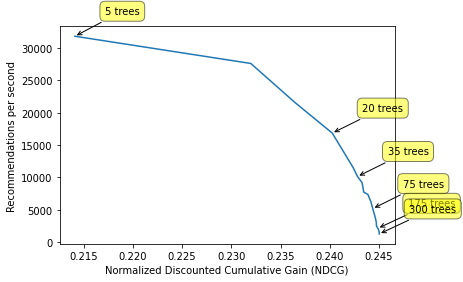

In [33]:
plt.plot(allndcgs3, allt3)
plt.ylabel("Recommendations per second")
plt.xlabel("Normalized Discounted Cumulative Gain (NDCG)")
for i in [0,7,9,14,18, 21]:
    plt.annotate(
            str(trees[i]) + " trees",
            xy=(allndcgs3[i], allt3[i]), xytext=(30, 30),
            textcoords='offset points', ha='left', va='top',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

content

In [34]:
Aknn_distances_brute_CB, Aknn_indices_brute_CB = sk_KNN_c(content_vec, items_itex, number_of_neighbours = 10)

ball_tree time: 22.65732431411743


In [58]:
8723/22.65732431411743

384.99691662906696

In [35]:
allt = []
allndcgs = []
for i in tqdm(range(20)):
    tt = []
    accs = []
    ndcgs = []
    trees = [5,6,7,8, 10,11,13, 15, 20, 30, 35, 40, 45, 50, 60, 75, 100, 125, 150, 175, 200, 250,  300]
    for i in trees:
        Tannoy_indices_CB, Tannoy_distances_CB, Tduration_CB = get_annoy_results_c(item_content_map, number_of_trees = i, number_of_neighbours = 10)
        tt.append(8723/Tduration_CB)
        accs.append(calc_acc(Tannoy_indices_CB, Aknn_indices_brute_CB, 10))
        ndcgs.append(calc_nDCG(Tannoy_indices_CB, Aknn_indices_brute_CB, 10))
    allt.append(tt)
    allndcgs.append(ndcgs)
allt = np.array(allt)
allndcgs = np.array(allndcgs)


  0%|          | 0/20 [00:00<?, ?it/s]

annoy time: 0.7424495220184326
annoy time: 0.6951406002044678
annoy time: 0.615203857421875
annoy time: 0.6364014148712158
annoy time: 0.6670629978179932
annoy time: 0.7139875888824463
annoy time: 0.6931097507476807
annoy time: 0.7077956199645996
annoy time: 0.760897159576416
annoy time: 1.3466041088104248
annoy time: 1.4057104587554932
annoy time: 1.4868378639221191
annoy time: 1.4024522304534912
annoy time: 1.3393299579620361
annoy time: 1.8173439502716064
annoy time: 1.7379875183105469
annoy time: 2.3821990489959717
annoy time: 2.8255615234375
annoy time: 2.937631607055664
annoy time: 3.5020101070404053
annoy time: 3.4327187538146973
annoy time: 5.123732089996338


  5%|▌         | 1/20 [00:44<14:10, 44.76s/it]

annoy time: 5.6050331592559814
annoy time: 0.7193396091461182
annoy time: 0.6713745594024658
annoy time: 0.626859188079834
annoy time: 0.8200607299804688
annoy time: 1.0569238662719727
annoy time: 0.8650186061859131
annoy time: 1.1759541034698486
annoy time: 0.732464075088501
annoy time: 0.9416768550872803
annoy time: 1.1612930297851562
annoy time: 1.5139212608337402
annoy time: 1.219956398010254
annoy time: 1.2811901569366455
annoy time: 1.4202251434326172
annoy time: 1.8670554161071777
annoy time: 1.8358287811279297
annoy time: 2.2501842975616455
annoy time: 2.566058874130249
annoy time: 3.2422397136688232
annoy time: 3.1382851600646973
annoy time: 3.497328042984009
annoy time: 4.708150625228882


 10%|█         | 2/20 [01:28<13:19, 44.44s/it]

annoy time: 4.867059230804443
annoy time: 0.5953576564788818
annoy time: 0.5954799652099609
annoy time: 0.5949375629425049
annoy time: 0.6022951602935791
annoy time: 0.6271777153015137
annoy time: 0.6403679847717285
annoy time: 0.663135290145874
annoy time: 0.7554161548614502
annoy time: 0.7484652996063232
annoy time: 0.9642713069915771
annoy time: 1.0090968608856201
annoy time: 1.418318510055542
annoy time: 1.132584571838379
annoy time: 1.1899333000183105
annoy time: 1.4825444221496582
annoy time: 1.9200630187988281
annoy time: 2.4891998767852783
annoy time: 3.2922868728637695
annoy time: 4.160708904266357
annoy time: 3.7114295959472656
annoy time: 3.775503635406494
annoy time: 5.158283472061157


 15%|█▌        | 3/20 [02:13<12:34, 44.38s/it]

annoy time: 4.830116033554077
annoy time: 0.755476713180542
annoy time: 0.5994467735290527
annoy time: 0.628476619720459
annoy time: 0.6687400341033936
annoy time: 0.6328539848327637
annoy time: 0.6651585102081299
annoy time: 0.7168257236480713
annoy time: 0.7202634811401367
annoy time: 0.8357250690460205
annoy time: 0.9833881855010986
annoy time: 1.092635154724121
annoy time: 1.300163984298706
annoy time: 1.1783077716827393
annoy time: 1.2282726764678955
annoy time: 1.358266830444336
annoy time: 1.5414588451385498
annoy time: 1.9165763854980469
annoy time: 2.213995933532715
annoy time: 3.0162136554718018
annoy time: 3.519498109817505
annoy time: 3.513902187347412
annoy time: 4.325608491897583


 20%|██        | 4/20 [02:55<11:35, 43.49s/it]

annoy time: 6.73054051399231
annoy time: 1.1753382682800293
annoy time: 1.28375244140625
annoy time: 1.1167690753936768
annoy time: 0.9450092315673828
annoy time: 1.323641061782837
annoy time: 0.9318985939025879
annoy time: 1.103841781616211
annoy time: 0.8329257965087891
annoy time: 0.9885504245758057
annoy time: 1.1992535591125488
annoy time: 1.3332221508026123
annoy time: 1.3695716857910156
annoy time: 1.81492280960083
annoy time: 1.8569858074188232
annoy time: 1.9441730976104736
annoy time: 2.207810163497925
annoy time: 3.0873310565948486
annoy time: 4.287561655044556
annoy time: 3.7091500759124756
annoy time: 4.562887191772461
annoy time: 4.538695573806763
annoy time: 6.316741466522217


 25%|██▌       | 5/20 [03:53<12:10, 48.73s/it]

annoy time: 7.198062181472778
annoy time: 1.030409574508667
annoy time: 0.9099807739257812
annoy time: 0.9171576499938965
annoy time: 1.0466372966766357
annoy time: 0.9371387958526611
annoy time: 1.1149959564208984
annoy time: 0.9641926288604736
annoy time: 1.1595134735107422
annoy time: 1.1480932235717773
annoy time: 1.5280604362487793
annoy time: 1.4525115489959717
annoy time: 1.8258166313171387
annoy time: 1.471966028213501
annoy time: 1.5042309761047363
annoy time: 2.6091151237487793
annoy time: 2.343616485595703
annoy time: 2.27284574508667
annoy time: 2.5648467540740967
annoy time: 2.8643553256988525
annoy time: 3.0281200408935547
annoy time: 3.4703688621520996
annoy time: 5.0604448318481445


 30%|███       | 6/20 [04:43<11:26, 49.04s/it]

annoy time: 5.607493877410889
annoy time: 0.7079329490661621
annoy time: 0.6829676628112793
annoy time: 0.7089884281158447
annoy time: 0.8653304576873779
annoy time: 0.8601741790771484
annoy time: 0.7589714527130127
annoy time: 0.8229751586914062
annoy time: 0.8039462566375732
annoy time: 1.0222864151000977
annoy time: 1.1562283039093018
annoy time: 1.1842248439788818
annoy time: 1.2723267078399658
annoy time: 1.4263191223144531
annoy time: 1.2990741729736328
annoy time: 1.6229298114776611
annoy time: 1.9333148002624512
annoy time: 2.4167447090148926
annoy time: 2.4896793365478516
annoy time: 3.1318182945251465
annoy time: 4.209501028060913
annoy time: 3.5032241344451904
annoy time: 4.379434823989868


 35%|███▌      | 7/20 [05:28<10:23, 48.00s/it]

annoy time: 6.530695676803589
annoy time: 0.8166906833648682
annoy time: 0.6183133125305176
annoy time: 0.6341674327850342
annoy time: 0.7853283882141113
annoy time: 0.696885347366333
annoy time: 0.7760462760925293
annoy time: 1.2022724151611328
annoy time: 1.1895532608032227
annoy time: 0.9489500522613525
annoy time: 1.0486176013946533
annoy time: 1.091416597366333
annoy time: 1.2800800800323486
annoy time: 1.2023663520812988
annoy time: 1.2923176288604736
annoy time: 1.6799497604370117
annoy time: 2.3883981704711914
annoy time: 1.938260555267334
annoy time: 2.907000780105591
annoy time: 3.26253342628479
annoy time: 3.7478675842285156
annoy time: 4.706857204437256
annoy time: 4.510461807250977


 40%|████      | 8/20 [06:16<09:32, 47.71s/it]

annoy time: 6.37331748008728
annoy time: 0.7044708728790283
annoy time: 0.693317174911499
annoy time: 0.9226870536804199
annoy time: 0.9742107391357422
annoy time: 0.8974483013153076
annoy time: 0.8552885055541992
annoy time: 1.3969590663909912
annoy time: 0.919849157333374
annoy time: 0.8513436317443848
annoy time: 1.232208013534546
annoy time: 1.1213512420654297
annoy time: 1.3517389297485352
annoy time: 1.4257681369781494
annoy time: 1.4686355590820312
annoy time: 2.028391122817993
annoy time: 1.787048101425171
annoy time: 2.451700210571289
annoy time: 2.3968775272369385
annoy time: 2.7897512912750244
annoy time: 3.2526140213012695
annoy time: 3.927546262741089
annoy time: 4.904734373092651


 45%|████▌     | 9/20 [07:03<08:43, 47.64s/it]

annoy time: 6.711952447891235
annoy time: 0.9215126037597656
annoy time: 0.8624813556671143
annoy time: 0.8487639427185059
annoy time: 0.7911379337310791
annoy time: 0.8595578670501709
annoy time: 0.8124239444732666
annoy time: 0.8731045722961426
annoy time: 0.8351387977600098
annoy time: 0.9976639747619629
annoy time: 1.8286330699920654
annoy time: 2.175236225128174
annoy time: 2.1962716579437256
annoy time: 2.421752452850342
annoy time: 2.321439266204834
annoy time: 2.7887017726898193
annoy time: 2.2687814235687256
annoy time: 2.3451600074768066
annoy time: 2.9488730430603027
annoy time: 3.3168513774871826
annoy time: 4.153924226760864
annoy time: 3.7391016483306885
annoy time: 5.1922876834869385


 50%|█████     | 10/20 [07:57<08:15, 49.53s/it]

annoy time: 5.64694356918335
annoy time: 0.9217784404754639
annoy time: 0.9638831615447998
annoy time: 0.8782620429992676
annoy time: 0.9136695861816406
annoy time: 1.0900535583496094
annoy time: 0.9137134552001953
annoy time: 1.6958589553833008
annoy time: 1.290172815322876
annoy time: 1.313025951385498
annoy time: 1.6423864364624023
annoy time: 1.5129342079162598
annoy time: 1.6043879985809326
annoy time: 1.9207415580749512
annoy time: 1.6647045612335205
annoy time: 2.06319522857666
annoy time: 2.4981746673583984
annoy time: 4.090469598770142
annoy time: 3.3138177394866943
annoy time: 3.6807215213775635
annoy time: 3.868231773376465
annoy time: 3.7696824073791504
annoy time: 4.869924545288086
annoy time: 7.277925491333008


 55%|█████▌    | 11/20 [08:53<07:45, 51.69s/it]

annoy time: 0.6799206733703613
annoy time: 0.6923246383666992
annoy time: 1.0617525577545166
annoy time: 0.8482074737548828
annoy time: 0.8605821132659912
annoy time: 0.7556056976318359
annoy time: 0.7773442268371582
annoy time: 0.8775639533996582
annoy time: 0.8800933361053467
annoy time: 1.2484462261199951
annoy time: 1.27860689163208
annoy time: 1.3141303062438965
annoy time: 1.9149305820465088
annoy time: 1.5797715187072754
annoy time: 1.3973946571350098
annoy time: 1.8455257415771484
annoy time: 2.1367595195770264
annoy time: 2.6309921741485596
annoy time: 3.0261952877044678
annoy time: 3.107654094696045
annoy time: 3.911008358001709
annoy time: 4.2051169872283936


 60%|██████    | 12/20 [09:38<06:35, 49.40s/it]

annoy time: 5.206525087356567
annoy time: 0.708350419998169
annoy time: 0.6639049053192139
annoy time: 0.667140007019043
annoy time: 0.7151927947998047
annoy time: 1.110931634902954
annoy time: 1.1272492408752441
annoy time: 0.999683141708374
annoy time: 0.9163229465484619
annoy time: 1.2082562446594238
annoy time: 1.2613489627838135
annoy time: 1.3747987747192383
annoy time: 1.5324137210845947
annoy time: 1.3676815032958984
annoy time: 1.4301369190216064
annoy time: 1.8986165523529053
annoy time: 2.1282994747161865
annoy time: 2.778740167617798
annoy time: 3.238734722137451
annoy time: 3.1017305850982666
annoy time: 3.8249762058258057
annoy time: 4.665234565734863
annoy time: 4.838927507400513


 65%|██████▌   | 13/20 [10:28<05:47, 49.62s/it]

annoy time: 6.2231597900390625
annoy time: 0.7022297382354736
annoy time: 0.6707193851470947
annoy time: 0.6686244010925293
annoy time: 0.6666824817657471
annoy time: 0.753868818283081
annoy time: 0.7387070655822754
annoy time: 0.7940270900726318
annoy time: 0.9234621524810791
annoy time: 0.97141432762146
annoy time: 1.0449986457824707
annoy time: 1.3806662559509277
annoy time: 1.4208486080169678
annoy time: 1.2079176902770996
annoy time: 1.3719325065612793
annoy time: 1.4725151062011719
annoy time: 1.7331278324127197
annoy time: 2.0729482173919678
annoy time: 2.9777963161468506
annoy time: 3.2863149642944336
annoy time: 3.673849582672119
annoy time: 4.5421507358551025
annoy time: 4.365871906280518


 70%|███████   | 14/20 [11:13<04:49, 48.27s/it]

annoy time: 5.662717819213867
annoy time: 0.6578919887542725
annoy time: 0.6888518333435059
annoy time: 1.100799798965454
annoy time: 1.0134680271148682
annoy time: 0.8932409286499023
annoy time: 0.6634776592254639
annoy time: 0.7378964424133301
annoy time: 0.7983558177947998
annoy time: 1.131324291229248
annoy time: 1.1332216262817383
annoy time: 1.1098546981811523
annoy time: 1.1399328708648682
annoy time: 1.299560546875
annoy time: 1.4860072135925293
annoy time: 1.9690487384796143
annoy time: 1.801490306854248
annoy time: 1.9227287769317627
annoy time: 2.248488664627075
annoy time: 2.7697484493255615
annoy time: 3.4752485752105713
annoy time: 3.695064067840576
annoy time: 4.085050344467163


 75%|███████▌  | 15/20 [11:56<03:53, 46.66s/it]

annoy time: 4.877049922943115
annoy time: 0.6148526668548584
annoy time: 0.6899209022521973
annoy time: 0.6399807929992676
annoy time: 0.6897809505462646
annoy time: 0.7009944915771484
annoy time: 0.6484286785125732
annoy time: 0.6910305023193359
annoy time: 0.7033696174621582
annoy time: 0.7696473598480225
annoy time: 1.0936427116394043
annoy time: 1.0477502346038818
annoy time: 1.0833468437194824
annoy time: 1.2403159141540527
annoy time: 1.314814805984497
annoy time: 1.3923444747924805
annoy time: 1.574535608291626
annoy time: 1.9380125999450684
annoy time: 2.237147569656372
annoy time: 2.615571975708008
annoy time: 2.9214694499969482
annoy time: 3.2501394748687744
annoy time: 3.996260643005371


 80%|████████  | 16/20 [12:34<02:56, 44.16s/it]

annoy time: 4.739866018295288
annoy time: 0.5979185104370117
annoy time: 0.603668212890625
annoy time: 0.8390462398529053
annoy time: 0.6162500381469727
annoy time: 0.8740489482879639
annoy time: 0.6340644359588623
annoy time: 0.6983330249786377
annoy time: 0.7053442001342773
annoy time: 0.762420654296875
annoy time: 0.9894289970397949
annoy time: 1.1075406074523926
annoy time: 1.0868942737579346
annoy time: 1.1597177982330322
annoy time: 1.2271959781646729
annoy time: 1.4660918712615967
annoy time: 1.56978178024292
annoy time: 1.9332695007324219
annoy time: 2.6525566577911377
annoy time: 2.8389852046966553
annoy time: 2.9962761402130127
annoy time: 3.235726833343506
annoy time: 3.9136126041412354


 85%|████████▌ | 17/20 [13:13<02:08, 42.67s/it]

annoy time: 4.849316358566284
annoy time: 0.6183364391326904
annoy time: 0.6498653888702393
annoy time: 0.7720236778259277
annoy time: 0.628791332244873
annoy time: 0.6418130397796631
annoy time: 0.6615560054779053
annoy time: 0.6774907112121582
annoy time: 0.6980056762695312
annoy time: 0.7901208400726318
annoy time: 1.265803337097168
annoy time: 1.253943920135498
annoy time: 1.0858674049377441
annoy time: 1.169504165649414
annoy time: 1.229992151260376
annoy time: 1.4541504383087158
annoy time: 1.5661766529083252
annoy time: 1.8970527648925781
annoy time: 2.2408738136291504
annoy time: 2.684934377670288
annoy time: 2.9081244468688965
annoy time: 3.2457988262176514
annoy time: 3.877141237258911


 90%|█████████ | 18/20 [13:52<01:22, 41.41s/it]

annoy time: 4.747134208679199
annoy time: 0.6598124504089355
annoy time: 0.6152956485748291
annoy time: 0.6194758415222168
annoy time: 0.7065966129302979
annoy time: 0.6555039882659912
annoy time: 0.6604592800140381
annoy time: 0.6840357780456543
annoy time: 0.898409366607666
annoy time: 0.7731161117553711
annoy time: 1.0036885738372803
annoy time: 1.058246374130249
annoy time: 1.1083650588989258
annoy time: 1.1734111309051514
annoy time: 1.2459328174591064
annoy time: 1.3772547245025635
annoy time: 1.6423864364624023
annoy time: 1.911203384399414
annoy time: 2.259571075439453
annoy time: 2.5675711631774902
annoy time: 3.059580087661743
annoy time: 3.2878568172454834
annoy time: 3.893432140350342


 95%|█████████▌| 19/20 [14:30<00:40, 40.46s/it]

annoy time: 4.713721752166748
annoy time: 0.6698105335235596
annoy time: 0.6077766418457031
annoy time: 0.6241669654846191
annoy time: 0.6780576705932617
annoy time: 0.7230162620544434
annoy time: 0.6540861129760742
annoy time: 0.678107500076294
annoy time: 0.7058045864105225
annoy time: 0.8889892101287842
annoy time: 0.987621545791626
annoy time: 1.036325216293335
annoy time: 1.0929558277130127
annoy time: 1.166663408279419
annoy time: 1.2281630039215088
annoy time: 1.4039263725280762
annoy time: 1.6783249378204346
annoy time: 2.1386969089508057
annoy time: 2.6534276008605957
annoy time: 3.0557448863983154
annoy time: 3.07568359375
annoy time: 3.383948802947998
annoy time: 3.8927509784698486


100%|██████████| 20/20 [15:10<00:00, 45.51s/it]

annoy time: 4.934077262878418


In [36]:
allt1 = np.mean(allt, axis = 0)
allndcgs1 = np.mean(allndcgs, axis = 0)

In [37]:
allt1

array([12011.32616064, 12510.01369968, 11766.15081606, 11510.30121294,
       10808.01243553, 11530.75127368, 10393.4717485 , 10496.26905345,
        9566.53798462,  7453.2981951 ,  7060.9626355 ,  6631.95400776,
        6414.43296233,  6238.64948543,  5189.12852877,  4695.14807739,
        3899.87805763,  3264.5739718 ,  2851.90382425,  2544.18656172,
        2357.70819081,  1934.81002915,  1573.32534962])

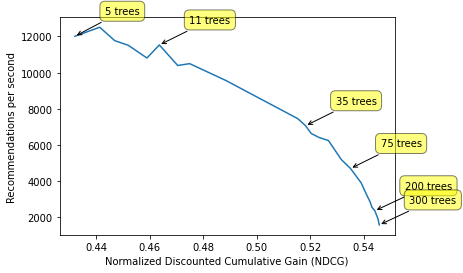

In [39]:
plt.plot(allndcgs1, allt1)
plt.ylabel("Recommendations per second")
plt.xlabel("Normalized Discounted Cumulative Gain (NDCG)")
for i in [0,5,10,15,20, 22]:
    plt.annotate(
            str(trees[i]) + " trees",
            xy=(allndcgs1[i], allt1[i]), xytext=(30, 30),
            textcoords='offset points', ha='left', va='top',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

## time - #features

In [65]:
alst = []
annoyt = []
knnt = []
accs = []
ndcgs = []
features = [5, 10, 20, 30, 40, 60, 80, 100, 120]
# matrix = ViewMatrix.load_matrix('./chetor.com/view_matrix/lil_matrix.npz')
# print('hi')
# sparce_matrix = matrix.to_csr()
# matrix.make_dense(user_min_view = 2, 
#                   item_min_view = 2)
# implicit_matrix = matrix.to_csr()
# print('hi')

In [42]:
for i in features:
    als_model = ALS.Als(num_factors = i,
                    iterations = 15,
                    num_threads = 15,
                    alpha = 15)
    now = time.time()
    als_model.fit(implicit_matrix)
    alst.append(time.time() - now)
    print(alst[-1])
    
    now = time.time()
    annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(als_model.item_vectors, number_of_neighbours = 10)
    annoyt.append(time.time() - now)
    
    now = time.time()
    knn_distances_brutei, knn_indices_brutei = sk_KNN(als_model.item_vectors, number_of_neighbours = 10)
    knnt.append(time.time() - now)
    
    accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
    ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))
    
    print(accs[-1], ndcgs[-1])
    

In [66]:
sparce_matrix5, implicit_matrix5, item_vectors5, user_vectors5, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 5)
alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors5, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors5, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

View matrix loaded in 7.092654705047607 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 16.765505075454712 seconds.

ALS model is fitted in 6.020764112472534 seconds.
Saving Data ...
annoy time: 3.9449942111968994
ball_tree time: 0.2891530990600586


In [67]:
sparce_matrix10, implicit_matrix10, item_vectors10, user_vectors10, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 10)
alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors10, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors10, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

View matrix loaded in 6.591866731643677 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 16.21094799041748 seconds.

ALS model is fitted in 7.890841007232666 seconds.
Saving Data ...
annoy time: 3.0883729457855225
ball_tree time: 0.5360774993896484


In [68]:
sparce_matrix20, implicit_matrix20, item_vectors20, user_vectors20, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 20)

alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors20, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors20, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

View matrix loaded in 6.4131927490234375 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 16.15778350830078 seconds.

ALS model is fitted in 11.246320009231567 seconds.
Saving Data ...
annoy time: 2.852264165878296
ball_tree time: 1.0006787776947021


In [69]:
sparce_matrix30, implicit_matrix30, item_vectors30, user_vectors30, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 30)

alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors30, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors30, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

View matrix loaded in 7.175655126571655 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 15.782491683959961 seconds.

ALS model is fitted in 19.233181953430176 seconds.
Saving Data ...
annoy time: 2.63493013381958
ball_tree time: 1.4874475002288818


In [70]:
sparce_matrix40, implicit_matrix40, item_vectors40, user_vectors40, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 40)

alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors40, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors40, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

View matrix loaded in 6.30347204208374 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 15.506009817123413 seconds.

ALS model is fitted in 93.17535543441772 seconds.
Saving Data ...
annoy time: 2.251936435699463
ball_tree time: 1.894446611404419


In [71]:
sparce_matrix60, implicit_matrix60, item_vectors60, user_vectors60, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 60)

alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors60, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors60, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

View matrix loaded in 6.31538462638855 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 15.348956108093262 seconds.

ALS model is fitted in 154.69891571998596 seconds.
Saving Data ...
annoy time: 2.499905824661255
ball_tree time: 3.271883487701416


In [72]:
sparce_matrix80, implicit_matrix80, item_vectors80, user_vectors80, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 80)


alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors80, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors80, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

View matrix loaded in 6.149060010910034 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 15.384785175323486 seconds.

ALS model is fitted in 342.1699721813202 seconds.
Saving Data ...
annoy time: 2.122102737426758
ball_tree time: 5.009122133255005


In [73]:
sparce_matrix100, implicit_matrix100, item_vectors100, user_vectors100, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 100)


alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors100, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors100, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

View matrix loaded in 6.200195550918579 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 15.818086385726929 seconds.

ALS model is fitted in 525.96914935112 seconds.
Saving Data ...
annoy time: 2.1418638229370117
ball_tree time: 7.082402944564819


In [74]:
sparce_matrix120, implicit_matrix120, item_vectors120, user_vectors120, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 120)

alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors120, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors120, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

View matrix loaded in 6.4216225147247314 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 15.928790092468262 seconds.

ALS model is fitted in 660.3781657218933 seconds.
Saving Data ...
annoy time: 2.0306851863861084
ball_tree time: 8.393351554870605


In [75]:
sparce_matrix140, implicit_matrix140, item_vectors140, user_vectors140, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 140)

alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors140, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors140, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

View matrix loaded in 6.098363399505615 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 15.618395328521729 seconds.

ALS model is fitted in 959.8455216884613 seconds.
Saving Data ...
annoy time: 2.091752052307129
ball_tree time: 10.081011533737183


In [76]:
sparce_matrix160, implicit_matrix160, item_vectors160, user_vectors160, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 160)

alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors160, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors160, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

View matrix loaded in 6.512907981872559 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 15.364351749420166 seconds.

ALS model is fitted in 1300.0534677505493 seconds.
Saving Data ...
annoy time: 1.9733662605285645
ball_tree time: 11.466623783111572


In [77]:
sparce_matrix180, implicit_matrix180, item_vectors180, user_vectors180, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 180)

alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors180, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors180, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

View matrix loaded in 6.210923671722412 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 15.411906242370605 seconds.

ALS model is fitted in 1716.3959829807281 seconds.
Saving Data ...
annoy time: 2.047321319580078
ball_tree time: 12.8496994972229


In [78]:
sparce_matrix200, implicit_matrix200, item_vectors200, user_vectors200, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 200)

alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors200, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors200, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

View matrix loaded in 6.234421253204346 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 15.300568342208862 seconds.

ALS model is fitted in 2775.904586315155 seconds.
Saving Data ...
annoy time: 2.0843958854675293
ball_tree time: 14.180020809173584


In [79]:
sparce_matrix220, implicit_matrix220, item_vectors220, user_vectors220, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 220)

alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors220, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors220, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

View matrix loaded in 6.222670555114746 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 15.583549737930298 seconds.

ALS model is fitted in 3462.4760234355927 seconds.
Saving Data ...
annoy time: 2.2141895294189453
ball_tree time: 15.363259553909302


In [ ]:
sparce_matrix240, implicit_matrix240, item_vectors240, user_vectors240, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 240)

alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors240, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors240, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

In [ ]:
sparce_matrix260, implicit_matrix260, item_vectors260, user_vectors260, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 260)

alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors260, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors260, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

In [ ]:
sparce_matrix280, implicit_matrix280, item_vectors280, user_vectors280, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 280)

alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors280, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors280, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

In [60]:
print(alst)
print(annoyt)
print(knnt)
print(accs)
print(ndcgs)

[7.289317607879639, 9.750426769256592, 14.307723760604858, 25.630435466766357, 141.31052207946777, 245.95699858665466, 531.0659351348877, 1182.7597563266754, 889.0909335613251, 2246.1444799900055, 3257.2178950309753]
[4.7668375968933105, 3.9713222980499268, 3.6236677169799805, 3.494922161102295, 2.913334369659424, 3.168506622314453, 2.6421518325805664, 2.6659493446350098, 3.134293794631958, 3.1395812034606934, 3.0914783477783203]
[0.3691706657409668, 0.6302402019500732, 1.2295241355895996, 1.8892674446105957, 2.3320982456207275, 5.420377492904663, 6.786769866943359, 7.923229217529297, 17.07801127433777, 14.070316791534424, 20.977322578430176]
[0.12670253502011536, 0.19889163556460343, 0.24400174494692453, 0.2736335288320165, 0.2908244874218409, 0.31389656342397365, 0.3343996897872134, 0.34385148562842327, 0.3570032152262776, 0.36887854846266943, 0.38015607580824967]
[0.10664456717637862, 0.16809047723368792, 0.206169213939166, 0.23102143279005524, 0.24551619649065584, 0.264600496497183

In [ ]:
alst = [7.289317607879639, 9.750426769256592, 14.307723760604858, 25.630435466766357, 141.31052207946777, 245.95699858665466, 531.0659351348877, 1182.7597563266754, 889.0909335613251, 2246.1444799900055]
annoyt = [4.7668375968933105, 3.9713222980499268, 3.6236677169799805, 3.494922161102295, 2.913334369659424, 3.168506622314453, 2.6421518325805664, 2.6659493446350098, 3.134293794631958, 3.1395812034606934]
knnt = [0.3691706657409668, 0.6302402019500732, 1.2295241355895996, 1.8892674446105957, 2.3320982456207275, 5.420377492904663, 6.786769866943359, 7.923229217529297, 17.07801127433777, 14.070316791534424]
accs = [0.12670253502011536, 0.19889163556460343, 0.24400174494692453, 0.2736335288320165, 0.2908244874218409, 0.31389656342397365, 0.3343996897872134, 0.34385148562842327, 0.3570032152262776, 0.36887854846266943]
ndcgs = [0.10664456717637862, 0.16809047723368792, 0.206169213939166, 0.23102143279005524, 0.24551619649065584, 0.26460049649718315, 0.2816905352556345, 0.2899726504051018, 0.3008974967463259, 0.3109966588301528]

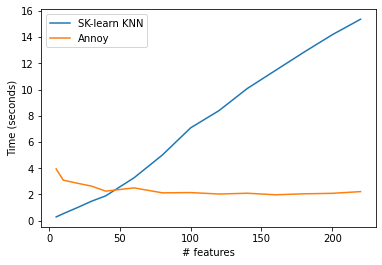

In [82]:
features = [5, 10, 20, 30, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220]
plt.plot(features, knnt, label = 'SK-learn KNN')
plt.plot(features, annoyt, label = 'Annoy')
plt.xlabel('# features')
plt.ylabel('Time (seconds)')
plt.legend(loc="upper left")

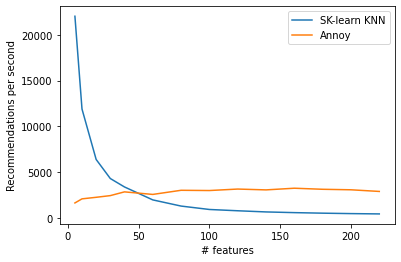

In [86]:
features = [5, 10, 20, 30, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220]
plt.plot(features, 6378/np.array(knnt), label = 'SK-learn KNN')
plt.plot(features, 6378/np.array(annoyt), label = 'Annoy')
plt.xlabel('# features')
plt.ylabel('Recommendations per second')
plt.legend(loc="upper right")

## acc-time-#features

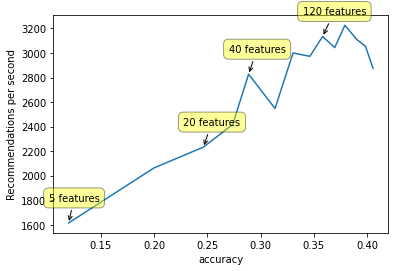

In [84]:
att = 6378/np.array(annoyt)
plt.plot(accs, att)
plt.ylabel("Recommendations per second")
plt.xlabel("accuracy")
for i in [0,2,4,8]:
    plt.annotate(
            str(features[i]) + " features",
            xy=(accs[i], att[i]), xytext=(-20, 30),
            textcoords='offset points', ha='left', va='top',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.4),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

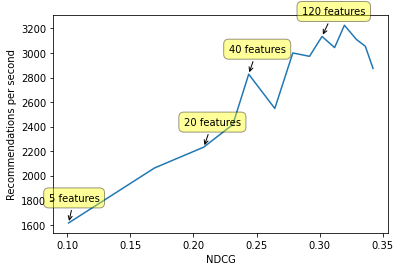

In [85]:
att = 6378/np.array(annoyt)
plt.plot(ndcgs, att)
plt.ylabel("Recommendations per second")
plt.xlabel("NDCG")
for i in [0,2,4,8]:
    plt.annotate(
            str(features[i]) + " features",
            xy=(ndcgs[i], att[i]), xytext=(-20, 30),
            textcoords='offset points', ha='left', va='top',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.4),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

## Precision Recall @k and MAE

In [28]:
now = time.time()
aproximated_matrix = np.matmul(user_vectors, np.transpose(item_vectors))
time.time() - now

19.879060983657837

In [30]:
start = time.time()
# implicit_matrix = implicit_matrix.toarray()
absolute_error = abs(aproximated_matrix - implicit_matrix)
time.time() - start

232.96968388557434

In [31]:
start = time.time()
MAE = absolute_error.mean()
time.time() - start

71.03863096237183

In [32]:
MAE

0.009043916284864414

In [27]:
idk = []
for i in tqdm(range(len(implicit_matrix))):
    temp = []
    for j in range(len(implicit_matrix[i])):
        if implicit_matrix[i][j] > 0:
            temp.append((implicit_matrix[i][j], j))
    idk.append(temp)

100%|██████████| 233197/233197 [18:19<00:00, 212.01it/s]


In [41]:
idk2 = []
for i in tqdm(range(len(aproximated_matrix))):
    temp = []
    for j in range(len(aproximated_matrix[i])):
        if aproximated_matrix[i][j] > 0.3:
            temp.append((aproximated_matrix[i][j], j))
    idk2.append(temp)

100%|██████████| 233197/233197 [15:20<00:00, 253.30it/s]


In [80]:
for i in tqdm(range(len(idk2))):
    idk2[i] = sorted(idk2[i], key=lambda x: x[0], reverse=True)

100%|██████████| 233197/233197 [00:00<00:00, 263142.36it/s]


In [86]:
def Precision_recall_at_k(idk2, idk, k):
    users_visited_indeces = \
    [[i[1] for i in idk[j]] for j in range(len(idk))]
#     print(users_visited_indeces[0:10])
    recommended_relevant = []
    relevants = []
    for i in range(len(idk2)):
        temp = 0
        if len(idk2[i]) >= k and len(users_visited_indeces[i]) >= k:
            for j in range(len(idk2[i][0:k+1])):
                if idk2[i][j][1] in users_visited_indeces[i]:
                    temp += 1
            recommended_relevant.append(temp)
            relevants.append(len(users_visited_indeces[i]))
    p = (np.array(recommended_relevant) / k).mean()
    r = []
    for i in zip(recommended_relevant, relevants):
        r.append(i[0]/i[1])
    r = np.array(r).mean()
    return p, r

In [87]:
for k in range(1, 20):
    print('k =', k, Precision_recall_at_k(idk2, idk, k))

k = 1 (0.7186354499231405, 0.3132991983320419)
k = 2 (0.45802332358454406, 0.39563191122090663)
k = 3 (0.3964406552864489, 0.33340775120759264)
k = 4 (0.3518457896857373, 0.28333117710725014)
k = 5 (0.3264939622252039, 0.2523960932844422)
k = 6 (0.31026053776903356, 0.231139391231143)
k = 7 (0.30018033558099416, 0.2186396367495723)
k = 8 (0.29234575087310827, 0.20980850487899763)
k = 9 (0.2872784150156413, 0.204103039836464)
k = 10 (0.2821524064171123, 0.1993732143623082)
k = 11 (0.27719190208605954, 0.1940893510669637)
k = 12 (0.2746406570841889, 0.19230763612031124)
k = 13 (0.2700897117770567, 0.18766172434375045)
k = 14 (0.2647549530761209, 0.1844010920044037)
k = 15 (0.25830429732868754, 0.17646792331281605)
k = 16 (0.2542162698412698, 0.17401698465680013)
k = 17 (0.24929360390444388, 0.17363907796836417)
k = 18 (0.244718792866941, 0.17004162464521388)
k = 19 (0.24428718855963436, 0.1696894556403601)


## popularity bias wrt alg

In [178]:
def CFTrain2(path: str, _alpha = 15, factors = 20):
    now = time.time()
    matrix = ViewMatrix.load_matrix(path)
    print('View matrix loaded in', time.time() - now, 'seconds.')

    now = time.time()
    sparce_matrix = matrix.to_csr()
    matrix.make_dense(user_min_view = 1, 
                      item_min_view = 1)
    print('matrix has been made dense in', time.time() - now, 'seconds.')

    als_model = ALS.Als(num_factors = factors,
                        iterations = 15,
                        num_threads = 15,
                        alpha = _alpha)

    implicit_matrix = matrix.to_csr()

    print()
    now = time.time()
    als_model.fit(implicit_matrix)
    alsTime = time.time() - now
    print('ALS model is fitted in', time.time() - now, 'seconds.')
    
    print('Saving Data ...')
    matrix.item_indexer.dump('./chetor.com/alisResult/ali_item_indexer_factorized.indexer')
    matrix.user_indexer.dump('./chetor.com/alisResult/ali_user_indexer_factorized.indexer')
    np.save('./chetor.com/alisResult/ali_items_vectors.npy', als_model.item_vectors)
    np.save('./chetor.com/alisResult/ali_users_vectors.npy', als_model.user_vectors)
    
    return sparce_matrix, implicit_matrix, als_model.item_vectors, als_model.user_vectors, alsTime

In [132]:
sparce_matrix, implicit_matrix, item_vectors, user_vectors, alsTime = \
CFTrain2('./chetor.com/view_matrix/lil_matrix.npz', factors = 20, _alpha = 1)

View matrix loaded in 8.806686878204346 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 26.60288381576538 seconds.

ALS model is fitted in 17.589404106140137 seconds.
Saving Data ...


In [166]:
implicit_matrix = implicit_matrix.toarray()

In [167]:
popularity_count = {}
for i, j in tqdm(enumerate(implicit_matrix.T)):
    popularity_count[i] = np.greater(j, 0).sum()

6877it [00:57, 118.72it/s]


In [168]:
site_trend = {k: v for k, v in sorted(popularity_count.items(), key=lambda item: item[1], reverse = True)}

In [169]:
len(site_trend)

6877

In [170]:
pop = []
item = []
for i, j in site_trend.items():
    pop.append(j)
    item.append(i)

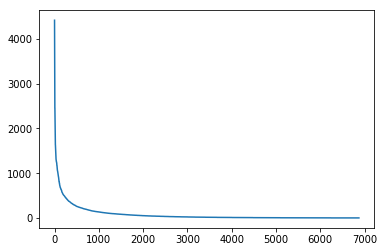

In [171]:
plt.plot(pop[3:])

In [172]:
ind, dis, d = get_annoy_results(item_vectors, number_of_neighbours = 30)
ind2 = []
for i in ind:
    ind2.append(i[1:])

annoy time: 5.80443811416626


In [173]:
ind2 = np.array(list((np.array(ind2)).flatten()))

In [157]:
knn_indices_brutei_st = np.array(list((np.array(knn_indices_brutei_st)).flatten()))

In [174]:
res = []
for i in item:
    res.append(np.equal(ind2, i).sum())

In [159]:
def a(s):
    r = []
    for i in range(len(s)-500):
        r.append(np.array(s[i:i+500]).mean())
    return r

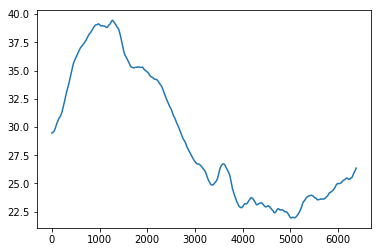

In [177]:
res = a(res)
plt.plot(res)